In [48]:
import pandas as pd
import numpy as np
import sys 
import os
import itertools
import time
import random

#import utils
sys.path.insert(0, '../utils/')
from utils_preprocess_v3 import *
from utils_modeling_v9 import *
from utils_plots_v2 import *

#sklearn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

start_time = time.time()

# load datasets

In [49]:
data = pd.read_csv('../data/datasets_processed/Harel_TIL_data.csv', index_col='Unnamed: 0')
response = pd.read_csv('../data/datasets_processed/Harel_TIL_response.csv', index_col='Unnamed: 0')
interactome = pd.read_csv('../data/interactomes/inbiomap_processed.txt', sep = '\t')

# preprocess

In [50]:
# get nodes from data and graph
data_nodes = data['node'].tolist()
interactome_nodes = list(set(np.concatenate((interactome['node1'], interactome['node2']))))

# organize data
organize = Preprocessing()
save_location = '../data/reduced_interactomes/reduced_interactome_Harel_TIL.txt'
organize.transform(data_nodes, interactome_nodes, interactome, data, save_location, load_graph = True)

In [51]:
# extract info from preprocessing
X = organize.sorted_X.T.values
y = response.values.reshape(-1,1)
L_norm = organize.L_norm
L = organize.L

g = organize.g
num_to_node = organize.num_to_node

# split for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=16)

# scaling X
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# scalying y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train).reshape(-1)
y_test = scaler_y.transform(y_test).reshape(-1)

In [52]:
# define training params
alpha_list = np.logspace(-1,0,15)
threshold_list = np.logspace(-3,-1,10)
max_features = 10

# Lasso 

In [6]:
VanillaLasso = LaplacianRegression('Lasso')
VanillaLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L = None, 
                  max_features = max_features, solver = cp.ECOS, force_features = True, verbose = False)

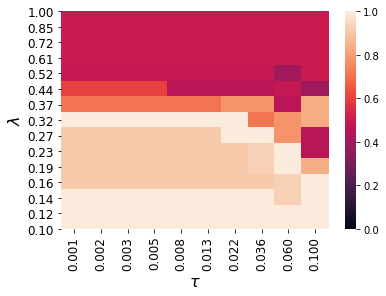

In [7]:
VanillaLasso.plotgridsearch()

In [8]:
print('Test MSE : ' ,VanillaLasso.predict(X_test, y_test))

Test MSE :  0.39476307859438076


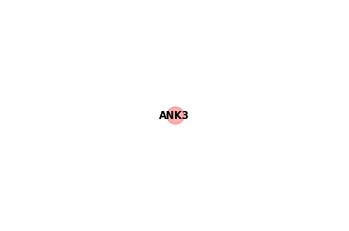

In [9]:
getTranslatedNodes(VanillaLasso.feats_, VanillaLasso.regr_.coef_, num_to_node, g,)

# NTF-Lasso

In [14]:
NTFLasso = LaplacianRegression('Lasso')
NTFLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L = L_norm, 
                  max_features = max_features, solver = cp.SCS, force_features = True, verbose = False)

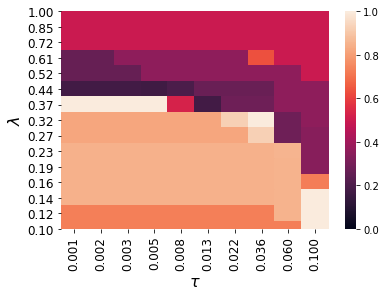

In [15]:
NTFLasso.plotgridsearch()

In [16]:
print('Test MSE : ' ,NTFLasso.predict(X_test, y_test))

Test MSE :  0.1641109330404994


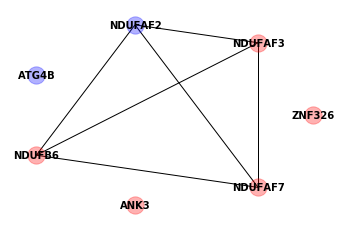

In [40]:
getTranslatedNodes(NTFLasso.feats_, NTFLasso.regr_.coef_, num_to_node, g)

# Ridge

In [18]:
VanillaRidge = LaplacianRegression('Ridge')
VanillaRidge.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L = None, 
                  max_features = max_features, solver = cp.ECOS, force_features = True, verbose = False)

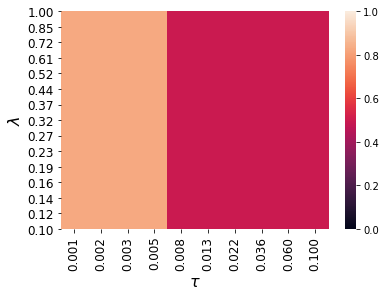

In [19]:
VanillaRidge.plotgridsearch()

In [20]:
print('Test MSE : ' ,VanillaRidge.predict(X_test, y_test))

Test MSE :  0.8300842827990114


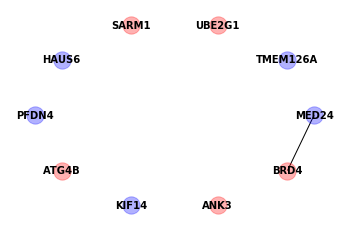

In [41]:
getTranslatedNodes(VanillaRidge.feats_, VanillaRidge.regr_.coef_, num_to_node, g,)

# NTF-Ridge

In [26]:
NTFRidge = LaplacianRegression('Ridge')
NTFRidge.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L = L_norm, 
                  max_features = max_features, solver = cp.SCS, force_features = True, verbose = False)

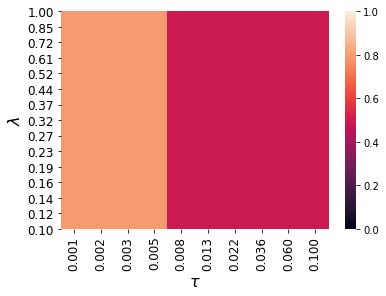

In [27]:
NTFRidge.plotgridsearch()

In [28]:
print('Test MSE : ' ,NTFRidge.predict(X_test, y_test))

Test MSE :  0.7906042856819189


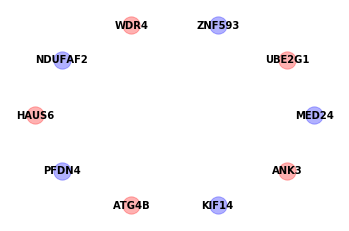

In [29]:
getTranslatedNodes(NTFRidge.feats_, NTFRidge.regr_.coef_, num_to_node, g, )

# TF-Lasso (Graph TF)

In [30]:
TFLasso = LaplacianRegression('Lasso')
TFLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L = L, 
                  max_features = max_features, solver = cp.SCS, solver_params = {'max_iters' : 10000},
                  force_features = True, verbose = False)

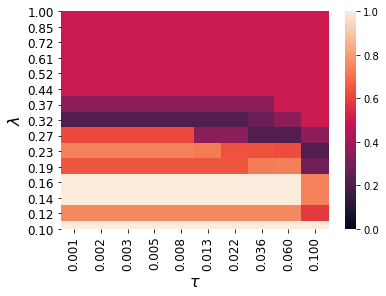

In [31]:
TFLasso.plotgridsearch()

In [32]:
print('Test MSE : ' ,TFLasso.predict(X_test, y_test))

Test MSE :  0.3488255347007707


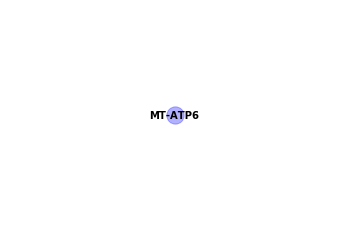

In [33]:
getTranslatedNodes(TFLasso.feats_, TFLasso.regr_.coef_, num_to_node, g,)

# Nonconvex Penalties (MCP, SCAD)

Training is over.
Test MSE :  0.39476307859438076


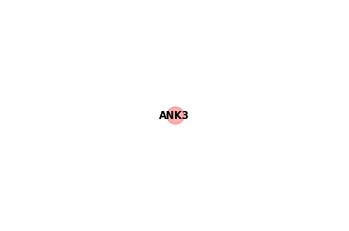

In [23]:
MCP = NonConvexRegression(penalty ='mcp')
MCP.fit(X_train, y_train, X_train, y_train, X_test, y_test, 
        alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,MCP.predict(X_test, y_test))
getTranslatedNodes(MCP.feats_, MCP.regr_.coef_, num_to_node, g, save_location = '../figures/TIL_MCP.png')

Training is over.
Test MSE :  0.39476307859438076


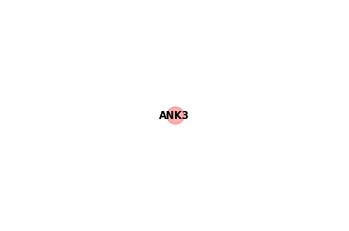

In [24]:
SCAD = NonConvexRegression(penalty = 'scad')
SCAD.fit(X_train, y_train, X_train, y_train, X_test, y_test, 
         alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,SCAD.predict(X_test, y_test))
getTranslatedNodes(SCAD.feats_, SCAD.regr_.coef_, num_to_node, g, save_location = '../figures/TIL_SCAD.png')

# NTF-Nonconvex Penalties (NTF-MCP, NTF-SCAD) 

In [53]:
L_norm_dagger = scipy.linalg.pinv(L_norm.todense())
X_train_new =  X_train.dot(L_norm_dagger)
X_test_new = X_test.dot(L_norm_dagger) 

Training is over.
Test MSE :  0.2728037172228188


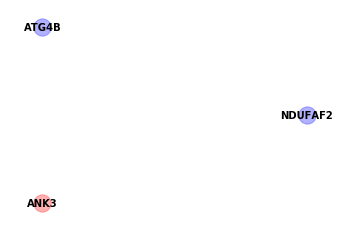

In [56]:
NTFMCP = NonConvexRegression(penalty ='mcp')
NTFMCP.fit(X_train_new, y_train, X_train, y_train, X_test, y_test, 
           alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,NTFMCP.predict(X_test, y_test))
getTranslatedNodes(NTFMCP.feats_, NTFMCP.regr_.coef_, num_to_node, g, save_location = '../figures/TIL_NTF-MCP.png')

Training is over.
Test MSE :  0.17213408343202038


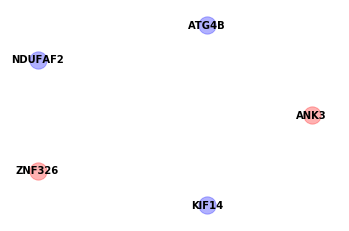

In [57]:
NTFSCAD = NonConvexRegression(penalty ='scad')
NTFSCAD.fit(X_train_new, y_train, X_train, y_train, X_test, y_test, 
            alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,NTFSCAD.predict(X_test, y_test))
getTranslatedNodes(NTFSCAD.feats_, NTFSCAD.regr_.coef_, num_to_node, g, save_location = '../figures/TIL_NTF-SCAD.png')


# Shuffled Features

In [42]:
# scramble feature order
random.seed(16)
feat_idx = list(range(X.shape[1]))
random.shuffle(feat_idx)
X_shuf = deepcopy(X[:,feat_idx])

# split for training
X_train, X_test, y_train, y_test = train_test_split(X_shuf, y, test_size=0.20, random_state=12)

# scaling X
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# scalying y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train).reshape(-1)
y_test = scaler_y.transform(y_test).reshape(-1)

In [79]:
ShuffledNTFLasso = LaplacianRegression('Lasso')
ShuffledNTFLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L = L_norm, 
                  max_features = max_features, solver = cp.SCS, force_features = True, verbose = False)

In [80]:
print('Test MSE : ' ,ShuffledNTFLasso.predict(X_test, y_test))

Test MSE :  0.2767686604936206


Training is over.
Test MSE :  0.2767686604936203


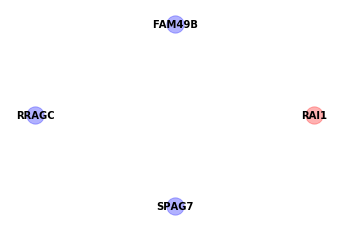

Training is over.
Test MSE :  0.30006343376734174


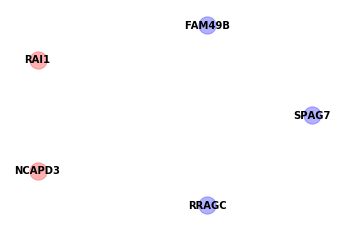

In [43]:
X_train_new =  X_train.dot(L_norm_dagger)
X_test_new = X_test.dot(L_norm_dagger) 

ShuffledNTFMCP = NonConvexRegression(penalty ='mcp')
ShuffledNTFMCP.fit(X_train_new, y_train, X_train, y_train, X_test, y_test, 
                   alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,ShuffledNTFMCP.predict(X_test, y_test))
getTranslatedNodes(ShuffledNTFMCP.feats_, ShuffledNTFMCP.regr_.coef_, num_to_node, g, save_location = '../figures/TIL_NTF-MCPshuf.png')


ShuffledNTFSCAD = NonConvexRegression(penalty ='scad')
ShuffledNTFSCAD.fit(X_train_new, y_train, X_train, y_train, X_test, y_test,
                    alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,ShuffledNTFSCAD.predict(X_test, y_test))
getTranslatedNodes(ShuffledNTFSCAD.feats_, ShuffledNTFSCAD.regr_.coef_, num_to_node, g, save_location = '../figures/TIL_NTF-SCADshuf.png')


#### Elapsed time

In [42]:
print( 'Elapsed Time : ', time.time() - start_time)

Elapsed Time :  49356.59288024902
